# Lab 6

You are tasked with evaluating card counting strategies for black jack. In order to do so, you will use object oriented programming to create a playable casino style black jack game where a computer dealer plays against $n$ computer players and possibily one human player. If you don't know the rules of blackjack or card counting, please google it. 

A few requirements:
* The game should utilize multiple 52-card decks. Typically the game is played with 6 decks.
* Players should have chips.
* Dealer's actions are predefined by rules of the game (typically hit on 16). 
* The players should be aware of all shown cards so that they can count cards.
* Each player could have a different strategy.
* The system should allow you to play large numbers of games, study the outcomes, and compare average winnings per hand rate for different strategies.

1. Begin by creating a classes to represent cards and decks. The deck should support more than one 52-card set. The deck should allow you to shuffle and draw cards. Include a "plastic" card, placed randomly in the deck. Later, when the plastic card is dealt, shuffle the cards before the next deal.

In [2]:
# Card class
class Card:
    suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
    ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'Jack', 'Queen', 'King', 'Ace']

    def __init__(self, suit, rank):
        self.suit = suit
        self.rank = rank

    def __repr__(self):
        return f'{self.rank} of {self.suit}'

    def value(self):
        if self.rank in ['Jack', 'Queen', 'King']:
            return 10
        elif self.rank == 'Ace':
            return 11  # or 1
        else:
            return int(self.rank)

In [3]:
import random

class Deck:
    def __init__(self, num_decks=6):
        self.num_decks = num_decks
        self.cards = []
        self.build_deck()
        self.shuffle_deck()
        self.insert_plastic_card()

    def build_deck(self):
        """Initialize with multiple 52-card sets."""
        self.cards = [Card(suit, rank) for suit in Card.suits for rank in Card.ranks] * self.num_decks

    def shuffle_deck(self):
        """Shuffle the deck."""
        random.shuffle(self.cards)

    def insert_plastic_card(self):
        """Include a plastic card randomly into the deck."""
        plastic_card_position = random.randint(0, len(self.cards) - 1)
        self.cards.insert(plastic_card_position, "Plastic")

    def draw_card(self):
        """Draw a card, and if the deck is empty, rebuild and shuffle it."""
        if len(self.cards) == 0:
            print("Deck is empty. Rebuilding and shuffling.")
            self.build_deck()
            self.shuffle_deck()

        card = self.cards.pop(0)

        if card == "Plastic":
            print("Plastic card dealt. Shuffling the deck.")
            self.build_deck()
            self.shuffle_deck()
            card = self.cards.pop(0)
            while card == "Plastic":
                card = self.cards.pop(0)

        return card

    def __repr__(self):
        return f"Deck of {len(self.cards)} cards"

In [4]:
# Test deck and drawing a card
deck = Deck()
print(deck)
print(deck.draw_card())
print(deck)

Deck of 313 cards
5 of Diamonds
Deck of 312 cards


2. Now design your game on a UML diagram. You may want to create classes to represent, players, a hand, and/or the game. As you work through the lab, update your UML diagram. At the end of the lab, submit your diagram (as pdf file) along with your notebook. 

3. Begin with implementing the skeleton (ie define data members and methods/functions, but do not code the logic) of the classes in your UML diagram.

In [5]:
# Player class with verbose mode
class Player:
    def __init__(self, chips, strategy, verbose=True):
        self.chips = chips
        self.hand = []
        self.strategy = strategy
        self.verbose = verbose

    def should_hit(self, dealer_card):
        """Basic strategy for hitting: hit if hand value is below 17."""
        return self.hand_value() < 17

    def hit(self, deck):
        """Draw a card and add to the player's hand"""
        card = deck.draw_card()
        if card:
            self.hand.append(card)
            if self.verbose:
                print(f"{self.__class__.__name__} hits: {card}")
        else:
            if self.verbose:
                print("No more cards in the deck!")

    def stand(self):
        """Decides to stand."""
        if self.verbose:
            print(f"{self.__class__.__name__} stands.")

    def hand_value(self):
        """Calculate the total value of the hand."""
        total_value = 0
        aces = 0
        for card in self.hand:
            total_value += card.value()
            if card.rank == 'Ace':
                aces += 1
        while total_value > 21 and aces:
            total_value -= 10
            aces -= 1
        return total_value

    def is_bust(self):
        """Check if the player is bust"""
        return self.hand_value() > 21

4. Complete the implementation by coding the logic of all functions. For now, just implement the dealer player and human player.

In [6]:
# Dealer class with verbose mode (inherits from Player)
class Dealer(Player):
    def __init__(self, verbose=True):
        super().__init__(chips=0, strategy='Dealer', verbose=verbose)

    def should_hit(self):
        """Dealer hits on 16 or less, stands on 17 or more."""
        return self.hand_value() < 17

    def hit(self, deck):
        """Override hit to track the dealer's move."""
        card = deck.draw_card()
        if card:
            self.hand.append(card)
            if self.verbose:
                print(f"Dealer hits: {card}")
        else:
            if self.verbose:
                print("No more cards in the deck!")

    def dealer_bust(self):
        """Check if the dealer busts"""
        if self.is_bust():
            if self.verbose:
                print("Dealer busts!")

# HumanPlayer class with verbose mode
class HumanPlayer(Player):
    def __init__(self, chips, verbose=True):
        super().__init__(chips, strategy="Human", verbose=verbose)

    def choose_action(self, deck):
        """Let player choose between hit or stand"""
        while True:
            action = input(f"Your hand value is {self.hand_value()}. Do you want to hit or stand? (h/s): ").lower()
            if action == 'h':
                self.hit(deck)
                if self.is_bust():
                    if self.verbose:
                        print("You bust!")
                    break
            elif action == 's':
                self.stand()
                break
            else:
                print("Invalid input, please choose 'h' to hit or 's' to stand.")


# Game class with verbose mode
class Game:
    def __init__(self, verbose=False):
        self.players = []
        self.dealer = Dealer()
        self.verbose = verbose

    def deal_cards(self, deck):
        """Deal initial cards to all players and dealer"""
        for player in self.players:
            player.hand = [deck.draw_card(), deck.draw_card()]
        self.dealer.hand = [deck.draw_card(), deck.draw_card()]

    def play_round(self, deck, bet_amount):
        """Play each player's turn"""
        for player in self.players:
            while player.should_hit(self.dealer.hand[0]):
                player.hit(deck)

        while self.dealer.should_hit():
            self.dealer.hit(deck)

    def determine_winner(self, bet_amount):
        """Determine the winner after each round"""
        dealer_hand_value = self.dealer.hand_value()

        if self.dealer.is_bust():
            if self.verbose:
                print("Dealer busts!")
            for player in self.players:
                if not player.is_bust():
                    player.chips += bet_amount
                    if self.verbose:
                        print(f"{player.__class__.__name__} wins because dealer busts!")
            return

        # Compare each player's hand to the dealer's and adjust chips based on the outcome
        for player in self.players:
            player_hand_value = player.hand_value()

            if player.is_bust():
                player.chips -= bet_amount
                if self.verbose:
                    print(f"{player.__class__.__name__} busts and loses {bet_amount} chips.")
            elif player_hand_value > dealer_hand_value:
                player.chips += bet_amount
                if self.verbose:
                    print(f"{player.__class__.__name__} wins and gains {bet_amount} chips.")
            elif player_hand_value < dealer_hand_value:
                player.chips -= bet_amount
                if self.verbose:
                    print(f"{player.__class__.__name__} loses {bet_amount} chips.")
            else:
                if self.verbose:
                    print(f"{player.__class__.__name__} ties with the dealer. No chips exchanged.")

5.  Test. Demonstrate game play. For example, create a game of several dealer players and show that the game is functional through several rounds.

In [7]:
def play_game(num_rounds=3, bet_amount=10):
    deck = Deck()

    game = Game()

    human1 = HumanPlayer(chips=100)
    game.players.append(human1)

    human2 = HumanPlayer(chips=150)
    game.players.append(human2)

    for round_num in range(1, num_rounds + 1):
        print(f"\n--- Round {round_num} ---\n")
        print(f"Deck before drawing: {len(deck.cards)} cards left.")

        game.deal_cards(deck)
        game.play_round(deck, bet_amount=bet_amount)
        game.determine_winner(bet_amount=bet_amount)

        for player in game.players:
            player.hand = []
        game.dealer.hand = []

    print(f"Deck after game: {len(deck.cards)} cards left.")

# Test playing 3 rounds
play_game(num_rounds=3, bet_amount=10)


--- Round 1 ---

Deck before drawing: 313 cards left.
HumanPlayer hits: Queen of Diamonds
HumanPlayer hits: 9 of Hearts
Dealer hits: Ace of Hearts

--- Round 2 ---

Deck before drawing: 304 cards left.
HumanPlayer hits: Jack of Clubs
Dealer hits: 10 of Clubs

--- Round 3 ---

Deck before drawing: 296 cards left.
Deck after game: 290 cards left.


6. Implement a new player with the following strategy:

    * Assign each card a value: 
        * Cards 2 to 6 are +1 
        * Cards 7 to 9 are 0 
        * Cards 10 through Ace are -1
    * Compute the sum of the values for all cards seen so far.
    * Hit if sum is very negative, stay if sum is very positive. Select a threshold for hit/stay, e.g. 0 or -2.  

In [8]:
# CardCountingPlayer class (inherits from Player)
class CardCountingPlayer(Player):
    def __init__(self, chips, hit_threshold=-2, stand_threshold=0, verbose=True):
        super().__init__(chips, strategy="Card Counting", verbose=verbose)
        self.running_count = 0
        self.hit_threshold = hit_threshold
        self.stand_threshold = stand_threshold

    def should_hit(self, dealer_card):
        """Card-counting strategy: hit if running count is below the hit threshold."""
        return self.running_count <= self.hit_threshold

    def assign_card_value(self, card):
        """Assign card values according to the counting strategy."""
        if card.rank in ['2', '3', '4', '5', '6']:
            return 1  # Low cards
        elif card.rank in ['7', '8', '9']:
            return 0
        else:
            return -1

    def update_running_count(self, card):
        """Update the running count based on the card's value."""
        card_value = self.assign_card_value(card)
        self.running_count += card_value

    def hit(self, deck):
        """Override hit to track the running count."""
        card = deck.draw_card()
        if card:
            self.hand.append(card)
            self.update_running_count(card)
            if self.verbose:
                print(f"{self.__class__.__name__} hits: {card}. Running count: {self.running_count}")
        else:
            if self.verbose:
                print("No more cards in the deck!")

7. Create a test scenario where one player, using the above strategy, is playing with a dealer and 3 other players that follow the dealer's strategy. Each player starts with same number of chips. Play 50 rounds (or until the strategy player is out of money). Compute the strategy player's winnings. You may remove unnecessary printouts from your code (perhaps implement a verbose/quiet mode) to reduce the output.

In [9]:
# Classes of Player, Dealer, HumanPlayer, Game and CardCountingPlayer have been modified with the verbose parameter to control the output

In [10]:
# Test card counting player against other players
def play_game_with_card_counter(num_rounds=50):
    deck = Deck()
    game = Game()

    card_counter = CardCountingPlayer(chips=100)
    game.players.append(card_counter)

    for _ in range(3):
        game.players.append(Player(chips=100, strategy="Dealer Strategy"))

    for round_num in range(1, num_rounds + 1):
        print(f"\n--- Round {round_num} ---\n")
        game.deal_cards(deck)
        game.play_round(deck, bet_amount=10)
        game.determine_winner(bet_amount=10)

        for player in game.players:
            player.hand = []
        game.dealer.hand = []

        if card_counter.chips <= 0:
            print("Card Counting Player is out of money!")
            break

    print(f"Deck after game: {len(deck.cards)} cards left.")

# Test playing 50 rounds
play_game_with_card_counter(num_rounds=50)


--- Round 1 ---

Player hits: Jack of Diamonds
Dealer hits: 8 of Clubs
Dealer hits: 7 of Spades

--- Round 2 ---

Dealer hits: 5 of Clubs
Dealer hits: 6 of Hearts

--- Round 3 ---

Player hits: 10 of Diamonds
Player hits: 4 of Hearts
Player hits: 9 of Hearts
Dealer hits: 4 of Clubs
Dealer hits: 5 of Clubs

--- Round 4 ---

Player hits: 6 of Spades

--- Round 5 ---

Player hits: 3 of Spades
Player hits: 2 of Hearts

--- Round 6 ---

Player hits: 6 of Spades
Player hits: 2 of Spades
Player hits: 5 of Diamonds

--- Round 7 ---

Player hits: 8 of Hearts
Player hits: Jack of Clubs

--- Round 8 ---

Player hits: King of Hearts
Player hits: 8 of Diamonds
Player hits: 3 of Diamonds
Dealer hits: 10 of Clubs

--- Round 9 ---

Player hits: 6 of Diamonds
Player hits: 10 of Spades

--- Round 10 ---

Player hits: 7 of Spades
Player hits: 8 of Clubs

--- Round 11 ---

Player hits: 7 of Diamonds
Player hits: 8 of Hearts
Player hits: 6 of Clubs
Player hits: 3 of Spades
Player hits: 10 of Clubs

--- Ro

8. Create a loop that runs 100 games of 50 rounds, as setup in previous question, and store the strategy player's chips at the end of the game (aka "winnings") in a list. Histogram the winnings. What is the average winnings per round? What is the standard deviation. What is the probabilty of net winning or lossing after 50 rounds?


Player hits: 7 of Clubs
Player hits: Jack of Diamonds
Dealer hits: 5 of Spades
Dealer hits: 3 of Hearts
Player hits: 7 of Diamonds
Player hits: 5 of Diamonds
Player hits: 4 of Spades
Dealer hits: 3 of Clubs
Player hits: King of Diamonds
Dealer hits: 2 of Diamonds
Dealer hits: 3 of Spades
Player hits: 4 of Spades
Player hits: 3 of Clubs
Player hits: 8 of Diamonds
Player hits: 4 of Hearts
Player hits: 6 of Hearts
Player hits: 9 of Clubs
Player hits: 2 of Hearts
Player hits: 8 of Diamonds
Player hits: 6 of Spades
Dealer hits: 3 of Diamonds
Dealer hits: Ace of Diamonds
Plastic card dealt. Shuffling the deck.
Player hits: Jack of Diamonds
Player hits: 7 of Hearts
Dealer hits: King of Clubs
Player hits: 4 of Spades
Player hits: 10 of Hearts
Player hits: 3 of Spades
Player hits: Queen of Clubs
Player hits: Jack of Hearts
Player hits: 9 of Clubs
Dealer hits: 2 of Clubs
Dealer hits: 5 of Diamonds
Dealer hits: 5 of Diamonds
Player hits: Jack of Hearts
Player hits: 9 of Diamonds
Player hits: 8 of

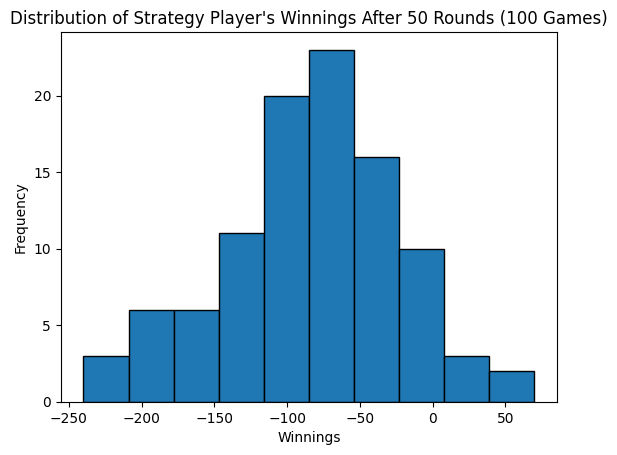

Average winnings per game: 16.5
Average winnings per round: 0.33
Standard deviation of winnings: 59.72227390178642
Probability of net winning after 50 rounds: 0.05
Probability of net losing after 50 rounds: 0.91


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Modified run_single_game to accept dynamic threshold
def run_single_game(strategy_player_starting_chips=100, bet_amount=10, hit_threshold=-2):
    deck = Deck()
    game = Game(verbose=False)

    strategy_player = CardCountingPlayer(chips=strategy_player_starting_chips, hit_threshold=hit_threshold)
    game.players.append(strategy_player)

    player1 = Player(chips=100, strategy='Basic')
    player2 = Player(chips=100, strategy='Basic')
    player3 = Player(chips=100, strategy='Basic')
    game.players.extend([player1, player2, player3])

    for _ in range(50):
        game.deal_cards(deck)
        game.play_round(deck, bet_amount=bet_amount)
        game.determine_winner(bet_amount=bet_amount)

        for player in game.players:
            player.hand = []
        game.dealer.hand = []

    return strategy_player.chips

# Run 100 games
winnings_list = []
for i in range(100):
    final_chips = run_single_game(strategy_player_starting_chips=100, bet_amount=10)
    winnings_list.append(final_chips - 100)

# histogram
plt.hist(winnings_list, bins=10, edgecolor='black')
plt.title("Distribution of Strategy Player's Winnings After 50 Rounds (100 Games)")
plt.xlabel("Winnings")
plt.ylabel("Frequency")
plt.show()

# average winnings per game and per round
average_winnings = np.mean(winnings_list) + 100
average_winnings_per_round = average_winnings / 50

# standard deviation for winnings
std_dev_winnings = np.std(winnings_list)

# probability for net winning/losing
probability_of_winning = np.sum(np.array(winnings_list) > 0) / len(winnings_list)
probability_of_losing = np.sum(np.array(winnings_list) < 0) / len(winnings_list)

print(f"Average winnings per game: {average_winnings}")
print(f"Average winnings per round: {average_winnings_per_round}")
print(f"Standard deviation of winnings: {std_dev_winnings}")
print(f"Probability of net winning after 50 rounds: {probability_of_winning}")
print(f"Probability of net losing after 50 rounds: {probability_of_losing}")

9. Repeat previous questions scanning the value of the threshold. Try at least 5 different threshold values. Can you find an optimal value?

In [12]:
def scan_thresholds(thresholds, num_games=100):
    results = {}

    for threshold in thresholds:
        print(f"Running for threshold: {threshold}")
        winnings_list = []

        for i in range(num_games):
            final_chips = run_single_game(strategy_player_starting_chips=100, bet_amount=10, hit_threshold=threshold)
            winnings_list.append(final_chips - 100)  # Store the net winnings

        average_winnings = np.mean(winnings_list)
        std_dev_winnings = np.std(winnings_list)
        probability_of_winning = np.sum(np.array(winnings_list) > 0) / len(winnings_list)

        results[threshold] = {
            "average_winnings": average_winnings,
            "std_dev": std_dev_winnings,
            "probability_of_winning": probability_of_winning
        }

    return results

In [13]:
thresholds = [-5, -3, -2, 0, 1]

results = scan_thresholds(thresholds)

for threshold, stats in results.items():
    print(f"Threshold: {threshold}")
    print(f"  Average winnings: {stats['average_winnings']}")
    print(f"  Standard deviation: {stats['std_dev']}")
    print(f"  Probability of net winning: {stats['probability_of_winning']}")
    print()

threshold_values = list(results.keys())
average_winnings = [results[t]["average_winnings"] for t in threshold_values]

plt.plot(threshold_values, average_winnings, marker='o')
plt.title("Average Winnings vs Threshold Values")
plt.xlabel("Hit Threshold")
plt.ylabel("Average Winnings")
plt.show()

Running for threshold: -5
Player hits: 4 of Hearts
Player hits: 7 of Clubs
Dealer hits: 2 of Clubs
Dealer hits: Ace of Spades
Dealer hits: Queen of Hearts
Player hits: 2 of Clubs
Player hits: 4 of Diamonds
Dealer hits: King of Clubs
Dealer hits: 6 of Diamonds
Player hits: 10 of Diamonds
Player hits: 8 of Hearts
Player hits: 4 of Clubs
Dealer hits: 2 of Clubs
Dealer hits: King of Spades
Player hits: 7 of Clubs
Player hits: 4 of Spades
Player hits: 5 of Hearts
Player hits: 3 of Clubs
Player hits: Queen of Diamonds
Player hits: 10 of Clubs
Player hits: 2 of Clubs
Player hits: Queen of Spades
Dealer hits: 2 of Clubs
Dealer hits: 3 of Spades
Dealer hits: 2 of Spades
Dealer hits: Ace of Hearts
Dealer hits: 7 of Diamonds
Player hits: 6 of Clubs
Dealer hits: Ace of Hearts
Dealer hits: 3 of Hearts
Dealer hits: 8 of Clubs
Player hits: 2 of Spades
Player hits: 7 of Spades
Player hits: 7 of Spades
Player hits: 3 of Diamonds
Player hits: Jack of Spades
Player hits: 10 of Spades
Player hits: Ace of 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



10. Create a new strategy based on web searches or your own ideas. Demonstrate that the new strategy will result in increased or decreased winnings. 

OmegaIICardCountingPlayer hits: 8 of Diamonds. Running count: 0
OmegaIICardCountingPlayer hits: 3 of Hearts. Running count: 1
Player hits: 5 of Hearts
Dealer hits: 10 of Diamonds
Player hits: Queen of Clubs
Player hits: 7 of Hearts
Player hits: 7 of Diamonds
Dealer hits: Ace of Diamonds
Player hits: 2 of Hearts
Player hits: 3 of Diamonds
Player hits: 4 of Hearts
Player hits: 10 of Clubs
Player hits: 9 of Clubs
Player hits: 2 of Diamonds
Player hits: 6 of Hearts
Player hits: 4 of Clubs
Player hits: 3 of Diamonds
Dealer hits: Jack of Spades
Player hits: Queen of Clubs
Player hits: Queen of Hearts
Player hits: King of Spades
Dealer hits: 2 of Spades
Dealer hits: Queen of Hearts
Player hits: 9 of Diamonds
Player hits: Jack of Spades
Player hits: 3 of Diamonds
Dealer hits: 4 of Spades
Dealer hits: 3 of Diamonds
Player hits: 6 of Diamonds
Player hits: 8 of Spades
Player hits: 4 of Clubs
Player hits: Jack of Spades
Dealer hits: 2 of Hearts
Dealer hits: 9 of Hearts
Player hits: 2 of Diamonds
P

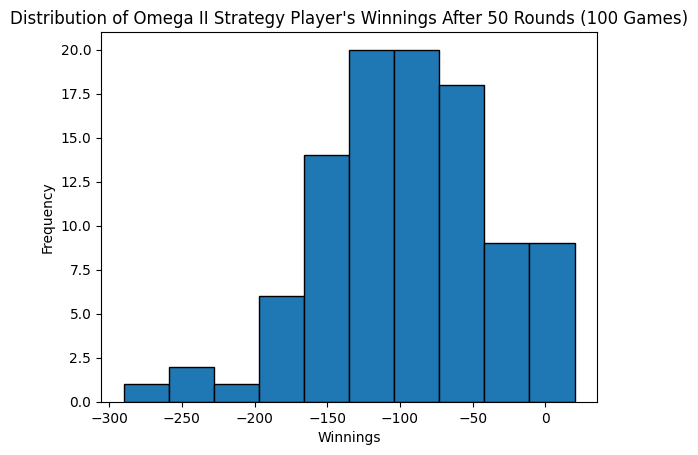

Average winnings per game: 3.9000000000000057
Average winnings per round: 0.07800000000000011
Standard deviation of winnings: 58.88794443687096
Probability of net winning after 50 rounds: 0.04
Probability of net losing after 50 rounds: 0.94


In [14]:
class OmegaIICardCountingPlayer(Player):
    def __init__(self, chips, verbose=True):
        super().__init__(chips, strategy="Omega II", verbose=verbose)
        self.running_count = 0

    def should_hit(self, dealer_card):
        """Omega II: simple decision to hit based on count."""
        return self.running_count <= 0  # Adjust this logic if needed

    def assign_card_value(self, card):
        """Omega II counting values."""
        if card.rank in ['2', '3', '7']:
            return 1
        elif card.rank in ['4', '5', '6']:
            return 2
        elif card.rank == '9':
            return -1
        elif card.rank in ['10', 'Jack', 'Queen', 'King']:
            return -2
        # 8 and Ace are zero
        return 0

    def update_running_count(self, card):
        self.running_count += self.assign_card_value(card)

    def hit(self, deck):
        card = deck.draw_card()
        if card:
            self.hand.append(card)
            self.update_running_count(card)
            if self.verbose:
                print(f"{self.__class__.__name__} hits: {card}. Running count: {self.running_count}")
        else:
            if self.verbose:
                print("No more cards in the deck!")
def run_single_game_with_omega(strategy_player_starting_chips=100, bet_amount=10):
    deck = Deck()  
    game = Game(verbose=False)  

    strategy_player = OmegaIICardCountingPlayer(chips=strategy_player_starting_chips)
    game.players.append(strategy_player)
    
    player1 = Player(chips=100, strategy='Basic')
    player2 = Player(chips=100, strategy='Basic')
    player3 = Player(chips=100, strategy='Basic')
    game.players.extend([player1, player2, player3])

    for _ in range(50):  
        game.deal_cards(deck)  
        game.play_round(deck, bet_amount=bet_amount)  
        game.determine_winner(bet_amount=bet_amount)  

        for player in game.players:
            player.hand = []
        game.dealer.hand = []
    
    return strategy_player.chips  
winnings_list = []
for i in range(100):
    final_chips = run_single_game_with_omega(strategy_player_starting_chips=100, bet_amount=10)  
    winnings_list.append(final_chips - 100)  

plt.hist(winnings_list, bins=10, edgecolor='black')
plt.title("Distribution of Omega II Strategy Player's Winnings After 50 Rounds (100 Games)")
plt.xlabel("Winnings")
plt.ylabel("Frequency")
plt.show()

import numpy as np
average_winnings = np.mean(winnings_list) + 100  
average_winnings_per_round = average_winnings / 50  

std_dev_winnings = np.std(winnings_list)

probability_of_winning = np.sum(np.array(winnings_list) > 0) / len(winnings_list)
probability_of_losing = np.sum(np.array(winnings_list) < 0) / len(winnings_list)

print(f"Average winnings per game: {average_winnings}")
print(f"Average winnings per round: {average_winnings_per_round}")
print(f"Standard deviation of winnings: {std_dev_winnings}")
print(f"Probability of net winning after 50 rounds: {probability_of_winning}")
print(f"Probability of net losing after 50 rounds: {probability_of_losing}")
